In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import random

In [3]:
data = np.genfromtxt('data/data_yerr.dat', names=True, comments='#', delimiter='&')
data

array([( 1., 201., 592., 61.), ( 2., 244., 401., 25.),
       ( 3.,  47., 583., 38.), ( 4., 287., 402., 15.),
       ( 5., 203., 495., 21.), ( 6.,  58., 173., 15.),
       ( 7., 210., 479., 27.), ( 8., 202., 504., 14.),
       ( 9., 198., 510., 30.), (10., 158., 416., 16.),
       (11., 165., 393., 14.), (12., 201., 442., 25.),
       (13., 157., 317., 52.), (14., 131., 311., 16.),
       (15., 166., 400., 34.), (16., 160., 337., 31.),
       (17., 186., 423., 42.), (18., 125., 334., 26.),
       (19., 218., 533., 16.), (20., 146., 344., 22.)],
      dtype=[('index', '<f8'), ('x', '<f8'), ('y', '<f8'), ('sigm_y', '<f8')])

I copied the code below from the Intro to Regression notebook:

In [4]:
def build_model(m, b):
    def model(x):
        return m * x + b
    return model

def lnlikelihood(m, b, x=data['x'], y=data['y'], sigma_y=data['sigm_y']):
    model = build_model(m, b)
    lnlike = -.5*np.sum(np.log(2*np.pi*sigma_y**2)) - np.sum((y - model(x))**2/(2*sigma_y**2)) 
    return lnlike

Let's define an initial m and b, sigma for the normal distribution of m and b, the number of steps in the chain, and arrays to store all the m and b values: 

In [5]:
m_current = 2
b_current = 100
sigma_m = .1
sigma_b = 10
N = 10000

ms = []
bs = []

Let's just say the prior is 1, so the posterior equals the likelihood. The for loop below generates a new m and b from a normal distribution centered around the current m and b, then calculates the posterior for the current m and b and the new m and b, then decides whether to accept or reject the new m and b based on whether the ratio of the posteriors is above a randomly generated number. If the new values are accepted, m and b are updated to the new m and b.

In [6]:
for _ in range(N):
    m_new = np.random.normal(loc=m_current, scale=sigma_m)
    b_new = np.random.normal(loc=b_current, scale=sigma_b)

    posterior_current = lnlikelihood(m_current, b_current)
    posterior_new = lnlikelihood(m_new, b_new)

    ratio = np.exp(posterior_new)/np.exp(posterior_current)

    accept_reject = np.random.uniform(low=0., high=1.)

    if ratio > accept_reject:
        m_current = m_new
        b_current = b_new
        ms.append(m_current)
        bs.append(b_current)
    else:
        ms.append(m_current)
        bs.append(b_current)

As we saw in the Intro to Regression notebook, a slope of about 1.08 and intercept of about 217 is an alright fit for the data, so let's see if our m and b settle around those values.

Text(0, 0.5, 'm')

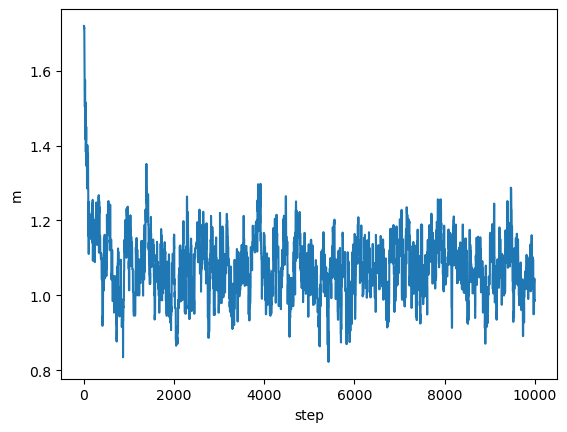

In [7]:
step = np.arange(1,N+1,1)
plt.plot(step,ms)
plt.xlabel('step')
plt.ylabel('m')

Text(0, 0.5, 'b')

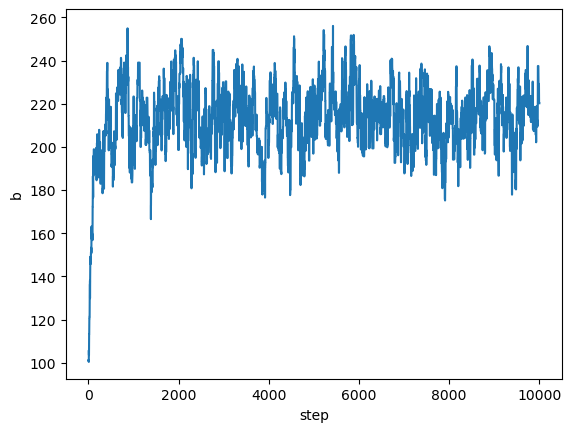

In [8]:
plt.plot(step,bs)
plt.xlabel('step')
plt.ylabel('b')

Now we want to remove the burn-in. I tried N=1000 earlier and saw that removing the first 200 m and b values should take care of the burn-in.

In [9]:
m_noburnin = ms[200:]
b_noburnin = bs[200:]
step_noburnin = step[200:]

Now let's generate the plots again to confirm that the burn-in is gone:

Text(0, 0.5, 'm')

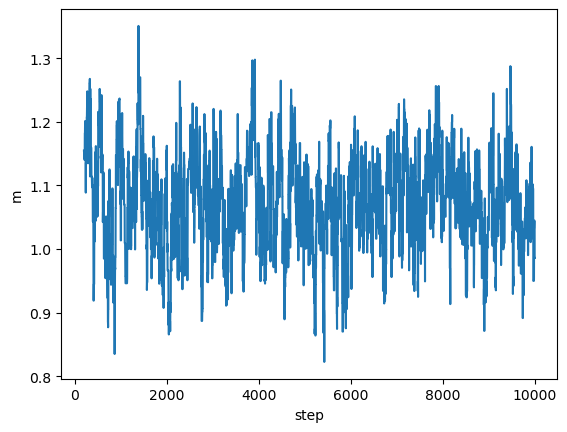

In [10]:
plt.plot(step_noburnin,m_noburnin)
plt.xlabel('step')
plt.ylabel('m')

Text(0, 0.5, 'b')

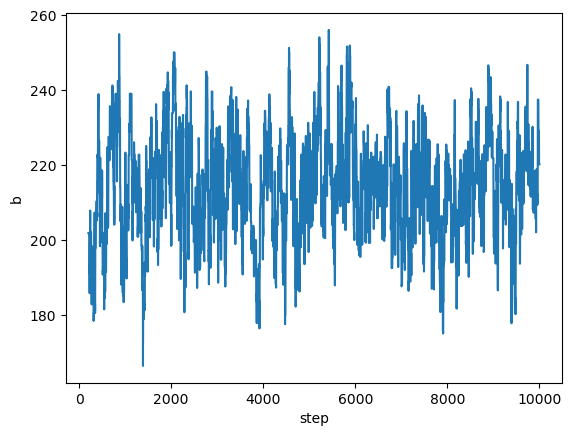

In [11]:
plt.plot(step_noburnin,b_noburnin)
plt.xlabel('step')
plt.ylabel('b')

Now to choose some m and b values to plot as y=mx+b and see how well they match the data. I'll choose 5 m&b pairs at random.

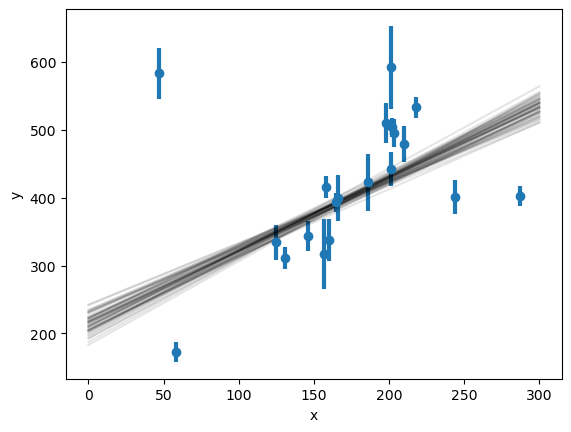

In [12]:
random_val = [random.randint(0, len(m_noburnin)) for _ in range(50)]

test_m = []
test_b = []

for i in range(len(random_val)):
    test_m.append(m_noburnin[random_val[i]])
    test_b.append(b_noburnin[random_val[i]])

xs = np.linspace(0,300,300)

plt.errorbar(data['x'], data['y'], yerr=data['sigm_y'], linewidth=0, elinewidth=3, marker='o')
for i in range(len(test_m)):
    plt.plot(xs, test_m[i] * xs + test_b[i], color='k', alpha=.1)
plt.xlabel('x')
plt.ylabel('y');

Not bad, but visually it looks like the slope should be higher and the y-intercept lower. Now let's plot the posterior distribution as a 2D histogram.

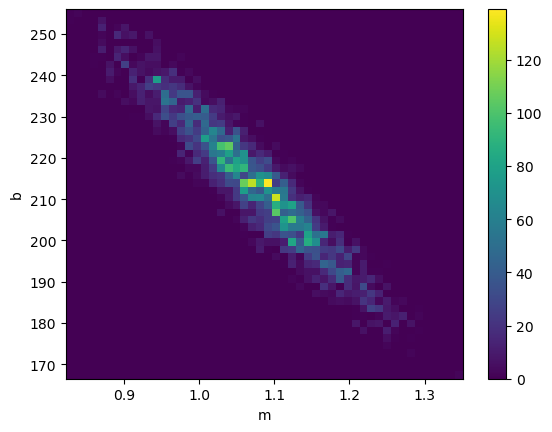

In [13]:
plt.hist2d(m_noburnin, b_noburnin, bins=50);
plt.xlabel('m')
plt.ylabel('b')
plt.colorbar()
plt.show()

The histogram above shows that the most m&b pairs occur just below m=1.1 and b=220. This makes sense because in class we found m=1.08 and b=213.

<span style="color:red">Great work!</span>

<span style="color:red">-Cristien</span>

# 510:

In [14]:
import pandas

To get the data from GAIA, I used the same query as in class except that I changed **AND parallax > 10** to **AND parallax > 40**.

In [15]:
df = pd.read_csv('data/gaia_data.csv')
df

FileNotFoundError: [Errno 2] No such file or directory: 'data/gaia_data.csv'

Copying code from class to make a color vs magnitude plot:

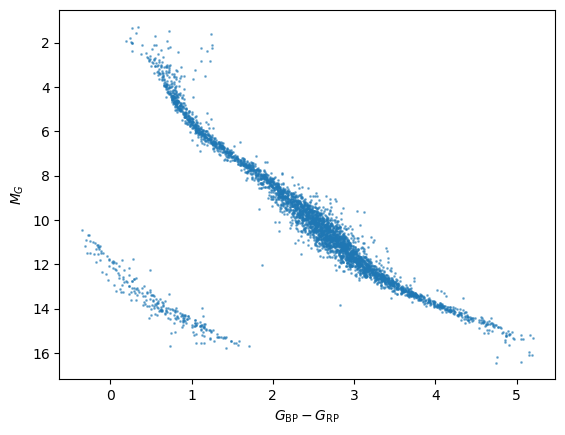

In [160]:
plt.scatter(df.bp_rp, df.mg, s=1, alpha=0.5)
plt.gca().invert_yaxis()
plt.xlabel(r"$G_\mathrm{BP} - G_\mathrm{RP}}$")
plt.ylabel(r"$M_G$");

Now I need to remove the white dwarfs, so let's make a line dividing them from the rest of the plot. Let's say the line has a y-intercept of 8 and an x intercept of 3, then I'll just make the slope negative, so $y = 8/3x + 8$.

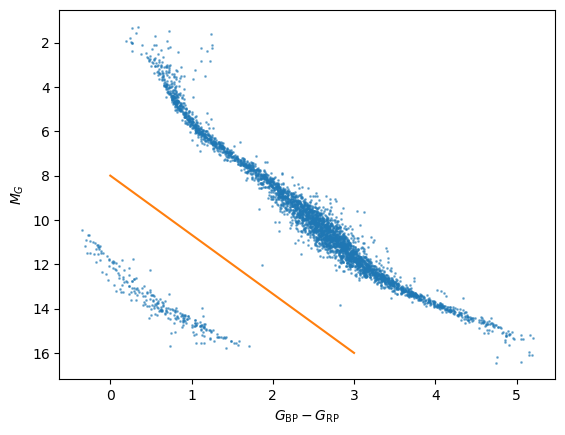

In [161]:
xs = np.linspace(0,3,50)
plt.scatter(df.bp_rp, df.mg, s=1, alpha=0.5)
plt.plot(xs, xs * 8/3 + 8, color='tab:orange')
plt.gca().invert_yaxis()
plt.xlabel(r"$G_\mathrm{BP} - G_\mathrm{RP}}$")
plt.ylabel(r"$M_G$");

To remove the white dwarfs from the data set, let's make a for loop that iterates through all the data and removes a row if the magnitude is below the line y=8/3x+8 for x=bp_rp.

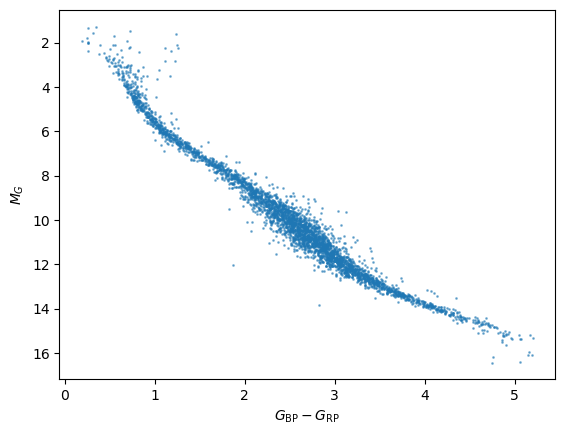

In [162]:
white_dwarfs = []

for i in range(0,4069):
    if df['mg'][i] > df['bp_rp'][i]*8/3+8:
        white_dwarfs.append(i) # make a list of rows to drop

main_seq = df.drop(white_dwarfs) # make a new dataframe with no white dwarfs

plt.scatter(main_seq.bp_rp, main_seq.mg, s=1, alpha=0.5)
plt.gca().invert_yaxis()
plt.xlabel(r"$G_\mathrm{BP} - G_\mathrm{RP}}$")
plt.ylabel(r"$M_G$");

First of all let's define a prior prior for $\sigma_{M_G}$ to make sure it doesn't run away or become negative. I chose to constrain it to $0<\sigma _{M_G}<10$.

In [259]:
def prior(σ):
    if σ < 10 and σ > 0:
        return 1
    else:
        return 0

Now let's define the likelihood just like for the other daata set, but this time also taking $\sigma$ as an argument:

In [245]:
def lnlikelihd(m, b, σ, x=main_seq['bp_rp'], y=main_seq['mg']):
    model = build_model(m, b)
    lnlike = -.5*np.sum(np.log(2*np.pi*σ**2)) - np.sum((y - model(x))**2/(2*σ**2)) 
    return lnlike

Now let's set up the initial m and b. I picked these values based on the line I used to cut the white dwarfs, since that line looks like about the right slope, but I wanted the initial slope and intercept guess to be off by a little so I can see the burn-in to confirm the MCMC is working like it should.

In [270]:
m_current = 2
b_current = 10
σ_current = 2

sigma_m = 1
sigma_b = 1
sigma_σ = 1

N = 10000

ms = [m_current]
bs = [b_current]
σs = [σ_current]

Now we can redo the Markov chain for loop from earlier, but this time the posterior equals the prior times the likelihood. To keep things in log form as much as possible, I made an if statement to make sure the prior is always satisfied for both the current $\sigma _{M_G}$ guess and the new $\sigma_{M_G}$ guess.

In [271]:
for _ in range(N):
    m_new = np.random.normal(loc=m_current, scale=sigma_m)
    b_new = np.random.normal(loc=b_current, scale=sigma_b)
    σ_new = np.random.normal(loc=σ_current, scale=sigma_σ)

    if prior(σ_current) == 1 and prior(σ_new) == 1:
        posterior_current = lnlikelihd(m_current, b_current, σ_current)
        posterior_new = lnlikelihd(m_new, b_new, σ_new)
        ratio = np.exp(posterior_new - posterior_current)
    else:
        ratio = 0

    accept_reject = np.random.uniform(low=0., high=1.)

    if ratio > accept_reject:
        m_current = m_new
        b_current = b_new
        σ_current = σ_new
        ms.append(m_current)
        bs.append(b_current)
        σs.append(σ_current)
    else:
        ms.append(m_current)
        bs.append(b_current)
        σs.append(σ_current)

/tmp/ipykernel_10187/2252578347.py:9: RuntimeWarning: overflow encountered in exp
  ratio = np.exp(posterior_new - posterior_current)


Now let's graph m, b, and $\sigma_{M_G}$ to see what values they settle around.

Text(0, 0.5, 'm')

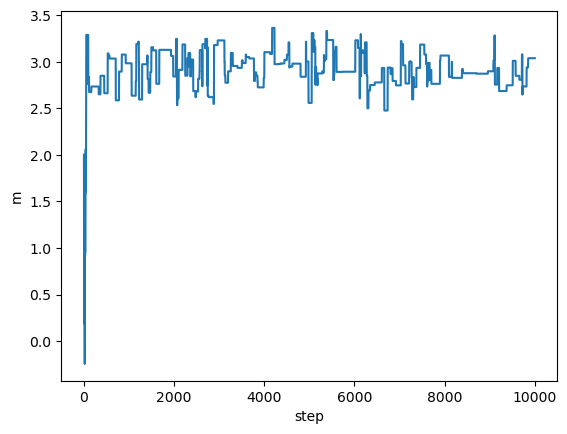

In [272]:
step = np.arange(0,N+1,1)
plt.plot(step,ms)
plt.xlabel('step')
plt.ylabel('m')

Text(0, 0.5, 'b')

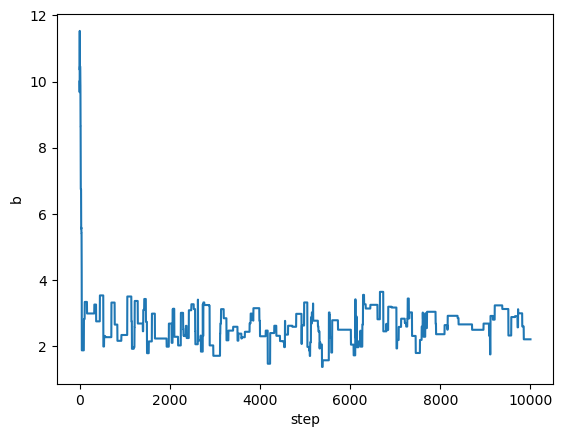

In [273]:
plt.plot(step,bs)
plt.xlabel('step')
plt.ylabel('b')

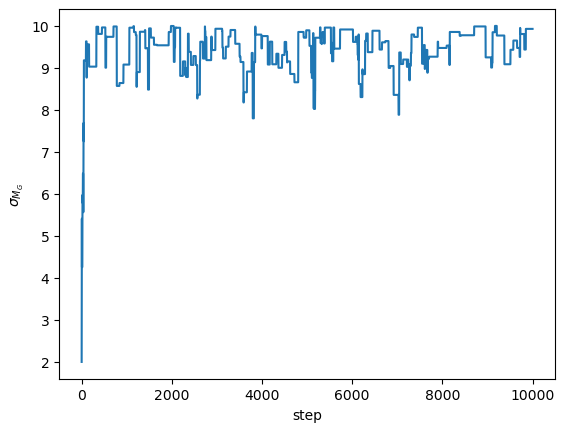

In [274]:
plt.plot(step,σs)
plt.xlabel('step')
plt.ylabel('$\sigma _{M_G}$');

The Markov chains above seemed to settle around consistent values, so let's graph a 50 sample lines against the main sequence data, taking off the first 100 steps as burn-in. I'll assign the $\sigma _{M_G}$ associated with each m&b pair as the error for all $M_G$ values.

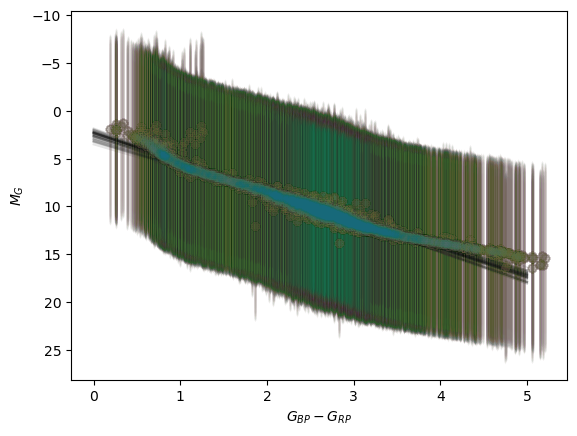

In [275]:
burnin = 100
m_noburnin = ms[burnin:]
b_noburnin = bs[burnin:]
σ_noburnin = σs[burnin:]
step_noburnin = step[burnin:]

random_val = [random.randint(0, len(m_noburnin)) for _ in range(50)] # generate 50 step numbers to plot

test_m = []
test_b = []
test_σ = []

for i in range(len(random_val)):
    test_m.append(m_noburnin[random_val[i]])
    test_b.append(b_noburnin[random_val[i]])
    test_σ.append(σ_noburnin[random_val[i]])

xs = np.linspace(0,5,50)

for i in range(len(test_m)):
    yerr = [test_σ[i]]*main_seq.shape[0] # assign the σ value as the error for every M_G value
    plt.errorbar(main_seq['bp_rp'], main_seq['mg'], yerr=yerr, alpha=0.01, linewidth=0, elinewidth=1, marker='o')
    plt.plot(xs, test_m[i] * xs + test_b[i], color='k', alpha=.1)
plt.gca().invert_yaxis()
plt.xlabel('$G_{BP}-G_{RP}$')
plt.ylabel('$M_G$');

This plot looks pretty ugly because of the error bars. A correlation between the constraints on the model parameters is that I tried constraining the error to be lower but it causes the Markov chain to accept a lot less samples. So for a lower constraint on $\sigma _{M_G}$ I would need a lot more steps in the chain. If I increase sigma_m or sigma_b, the chain also accept less steps, but I think increasing them might be a benefit if my initial guesses for m and b were very far off.

To get a better look at how well the lines fit, let's graph it without error bars.

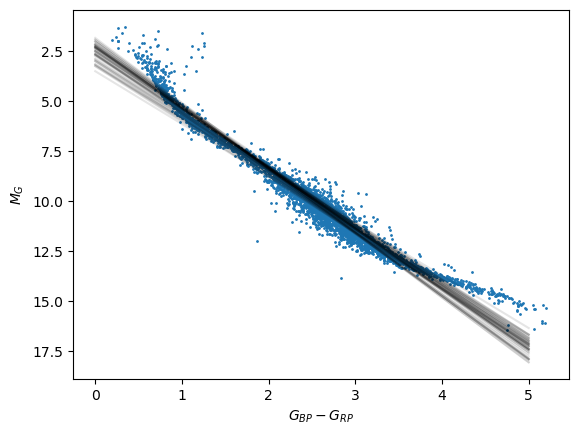

In [276]:
plt.scatter(main_seq['bp_rp'], main_seq['mg'], s=1)
for i in range(len(test_m)):
    plt.plot(xs, test_m[i] * xs + test_b[i], color='k', alpha=.1)
plt.gca().invert_yaxis()
plt.xlabel('$G_{BP}-G_{RP}$')
plt.ylabel('$M_G$');

I infered that $\sigma _{M_g}<10$. The scatter about the line looks to be much less than what the error bar plot showed.

<span style="color:red">Well done!</span>

<span style="color:red">-Cristien</span>